In [1]:
!git clone https://github.com/pdhruv93/Lane-Detection-In-Video.git

Cloning into 'Lane-Detection-In-Video'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 0), reused 5 (delta 0), pack-reused 0
Unpacking objects: 100% (5/5), done.


In [2]:
%cd Lane-Detection-In-Video
!ls

/content/Lane-Detection-In-Video
Lane_Detector.ipynb  test_image.jpg  test_video.mp4


In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [0]:
def convertToCannyImage(image):
    #convert to grayscale
    gray_image=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    #remove noise from image
    blurred_image=cv2.GaussianBlur(gray_image,(5,5),0)

    #detect intensity gradient in image
    canny_image=cv2.Canny(blurred_image,50,150)
    
    return canny_image

In [0]:
def regionOfInterest(image):
    height=image.shape[0]
    
    #defining region of interest
    triangle=np.array([[(200,height),(1100,height),(550,250)]])
    #here we have created 2d array as fillPoly method expects array of polygon.currently we have only 1 ploygon(triangle) 
    
    #creating black image
    black_image=np.zeros_like(image)
    
    #creating mask-- 255 is white color lines
    mask=cv2.fillPoly(black_image,triangle,255)
    
    #applying mask on original image
    masked_image=cv2.bitwise_and(image,mask)
    
    return masked_image

In [0]:
#display lines over a image
def displayLines(image,lines):
    line_image=np.zeros_like(image) #black image
    if lines is not None:
        for line in lines:
            #print(line) --output like [[704 418 927 641]] this is 2d array representing [[x1,y1,x2,y2]] for each line
            x1,y1,x2,y2=line.reshape(4) #converting to 1d array []

            #draw line over black image --(255,0,0) tells we want to draw blue line (b,g,r) values
            #10 is line thickness
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
    return line_image

In [0]:
def getSmoothLines(image,lines):
    left_fit=[]  #will hold m,c parameters for left side lines
    right_fit=[] #will hold m,c parameters for right side lines
    
    for line in lines:
        x1,y1,x2,y2=line.reshape(4)
        #polyfit gives slope(m) and intercept(c) values from input points
        #last parameter 1 is for linear..so it will give linear parameters m,c
        parameters=np.polyfit((x1,x2),(y1,y2),1)
        slope=parameters[0]
        intercept=parameters[1]
        
        if slope<0:
            left_fit.append((slope,intercept))
        else:
            right_fit.append((slope,intercept))
    
    #take averages of all intercepts and slopes separately and get 1 single value for slope,intercept
    #axis=0 means vertically...see its always (row,column)...so row is always 0 position.
    #so axis 0 means over row(vertically)
    left_fit_average=np.average(left_fit,axis=0)
    right_fit_average=np.average(right_fit,axis=0)
    
    #now we have got m,c parameters for left and right line, we need to know x1,y1 x2,y2 parameters
    left_line=getLineCoordinatesFromParameters(image,left_fit_average)
    right_line=getLineCoordinatesFromParameters(image,right_fit_average)
    return np.array([left_line,right_line])

In [0]:
def getLineCoordinatesFromParameters(image,line_parameters):
        slope=line_parameters[0]
        intercept=line_parameters[1]
        y1=image.shape[0] #since line willl always start from bottom of image
        y2=int(y1*(3/5)) #some random point at 3/5
        x1=int((y1-intercept)/slope)
        x2=int((y2-intercept)/slope)
        return np.array([x1,y1,x2,y2])

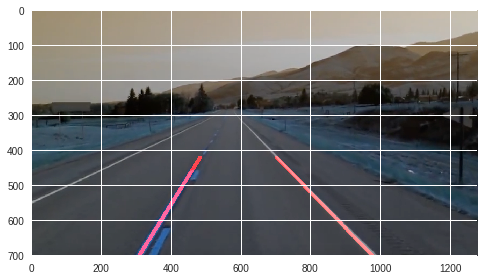

In [9]:
#read from image
image=cv2.imread('test_image.jpg')
lane_image=np.copy(image)

canny_image=convertToCannyImage(lane_image)
masked_image=regionOfInterest(canny_image)

#finding lines 
#lines=cv2.HoughLinesP(image,bin_size,precision,threshold,dummy 2d array--no use,minLineLength,maxLineGap)
#lets take bin size to be 2 pixels
#lets take precision to be 1 degree= pi/180 radians
#threshold is the votes that a bin should have to be accepted to draw a line
#minLineLength --the minimum length in pixels a line should have to be accepted.
#maxLineGap --the max gap between 2 broken line which we allow for 2 lines to be connected together.
lines=cv2.HoughLinesP(masked_image,2,np.pi/180,100,np.array([]),minLineLength=40,maxLineGap=5)

lines_image=displayLines(lane_image,lines) #lines over black image

#show lines_image over original image-- the idea here is that lines_image has color intensity of 0(black)
#so when we add this to original image, it wont affect the original image except the places whihc have lines(color!=0)
#the 2nd argument will do lane_image*0.8 -- we want to decrease intensity of lines
#the 4th argument will do original image*1 -- we want no intensity change
#the last argument is just a scalar
combo_image=cv2.addWeighted(lane_image,0.8,lines_image,1,1)

smooth_lines=getSmoothLines(lane_image,lines)
smooth_lines_image=displayLines(lane_image,smooth_lines) #lines over black image
smooth_lines_combo_image=cv2.addWeighted(lane_image,0.8,smooth_lines_image,1,1)


#show image
plt.imshow(smooth_lines_combo_image,shape=(50,50))
plt.show()